# IMU Case

In [1]:
%load_ext autoreload
%autoreload 2

## 1. Data Preprocessing

In [2]:
import pandas as pd, numpy as np

In [3]:
# --- Data Loading and Merging ---
# Merge CSV files
files = ["IMU_case_dataset_part1_.csv", "IMU_case_dataset_part2_.csv",
         "IMU_case_dataset_part3_.csv", "IMU_case_dataset_part4_.csv"]
df_list = [pd.read_csv(f"data/{f}") for f in files]
df = pd.concat(df_list, ignore_index=True)

# Drop duplicate rows (if any overlap at file boundaries) or any feature is NaN
df.drop_duplicates(subset=['ID','timestamp'], inplace=True)
df.dropna(subset=['idx', 'ID', 'timestamp', 'X', 'Y', 'Z'], inplace=True)

# Sort by ID, then by timestamp
df = df.sort_values(['ID', 'timestamp']).reset_index(drop=True)
print("Combined data shape:", df.shape)
print("Example records:\n", df.head(5))

# Percentage of unlabelled data
pcntUnlAct = (1 - sum(df["activity"].notna()) / len(df)) * 100
print(f"\nAbout {round(pcntUnlAct)}% data is not labelled!")

Combined data shape: (1031005, 7)
Example records:
       idx  ID activity      timestamp     X      Y     Z
0  941965   1      NaN  4991922345000  0.69  10.80 -2.03
1  941966   1  Walking  4991972333000  6.85   7.44 -0.50
2  941967   1  Walking  4992022351000  0.93   5.63 -0.50
3  941968   1  Walking  4992072339000 -2.11   5.01 -0.69
4  941969   1  Walking  4992122358000 -4.59   4.29 -1.95

About 60% data is not labelled!


## 2. Feature Extraction

In [4]:
from utilities import extract_features_and_labels

In [5]:
# --- Sliding Window Segmentation and Feature Extraction ---
WINDOW_SIZE = 100   # number of samples per window
STEP_SIZE = 50     # 50% overlap
MAJ_FRAC = 0.4      # required fraction to assign label to a window
feature_rows, labels, win_ids, acc, ts = extract_features_and_labels(df, WINDOW_SIZE, STEP_SIZE, MAJ_FRAC)
labels, win_ids, acc, ts = np.array(labels), np.array(win_ids), np.array(acc), np.array(ts)

In [6]:
# Create DataFrame of features
feature_df = pd.DataFrame(feature_rows)
feature_df['label'] = labels
feature_df['ID'] = win_ids

In [7]:
# Remove rows with feature as NAN
mask_nan_feats = feature_df.drop(columns=['label']).isna().sum(axis=1) != 0
feature_df = feature_df[~mask_nan_feats]
labels, win_ids, acc, ts = labels[~mask_nan_feats], win_ids[~mask_nan_feats], acc[~mask_nan_feats], ts[~mask_nan_feats]

feature_df

,mean_X,mean_Y,mean_Z,std_X,std_Y,std_Z,min_X,min_Y,min_Z,max_X,...,mean_mag,std_mag,dom_freq_X,dom_freq_Y,dom_freq_Z,corr_XY,corr_XZ,corr_YZ,label,ID
0,3.6538,9.8101,-0.478800,5.508084,3.914714,3.201477,-7.35,2.37,-7.040000,19.57,...,11.927003,4.845368,0.19,0.10,0.10,0.316664,0.675447,0.011866,Walking,1
1,3.8087,9.8923,-0.687800,5.562401,4.293310,3.203771,-9.58,2.37,-8.050000,19.57,...,12.115611,5.068116,0.19,0.10,0.24,0.301360,0.631326,-0.097338,Walking,1
2,3.9234,9.9414,-0.678300,5.903331,4.400147,3.365976,-9.58,1.84,-9.150000,19.57,...,12.371288,5.213082,0.10,0.10,0.10,0.324586,0.576068,-0.020536,Walking,1
3,4.0386,10.1268,-0.533500,5.750473,4.382012,3.514250,-8.24,1.73,-9.150000,19.57,...,12.569313,5.077330,0.10,0.10,0.10,0.270760,0.590267,0.013171,Walking,1
4,3.7830,9.9995,-0.590100,5.847101,4.675434,3.465680,-8.96,1.33,-8.310000,19.57,...,12.434808,5.299440,0.10,0.10,0.10,0.350321,0.589238,0.004393,Walking,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20560,-1.3264,9.4234,2.504510,0.101317,0.045546,0.064987,-1.53,9.34,2.369940,-1.08,...,9.841093,0.042740,0.02,0.02,0.01,0.315904,-0.071094,-0.127888,Standing,36
20561,-1.2796,9.4433,2.459971,0.098843,0.047033,0.057943,-1.50,9.30,2.342700,-1.08,...,9.842642,0.049772,0.01,0.14,0.02,0.107484,-0.003434,0.144373,Standing,36
20562,-1.3304,9.4261,2.491843,0.113463,0.062800,0.079218,-1.69,9.28,2.342700,-1.14,...,9.841247,0.059607,0.03,0.01,0.01,0.307973,-0.523127,-0.188623,Standing,36
20563,-1.3643,9.4271,2.463648,0.137595,0.083490,0.119740,-1.73,9.23,2.152015,-1.04,...,9.840421,0.086258,0.02,0.02,0.01,0.122436,-0.241409,-0.019276,Standing,36


## 3. Exploratory Data Analysis

In [8]:
import matplotlib.pyplot as plt, seaborn as sns
sns.set_style("darkgrid")

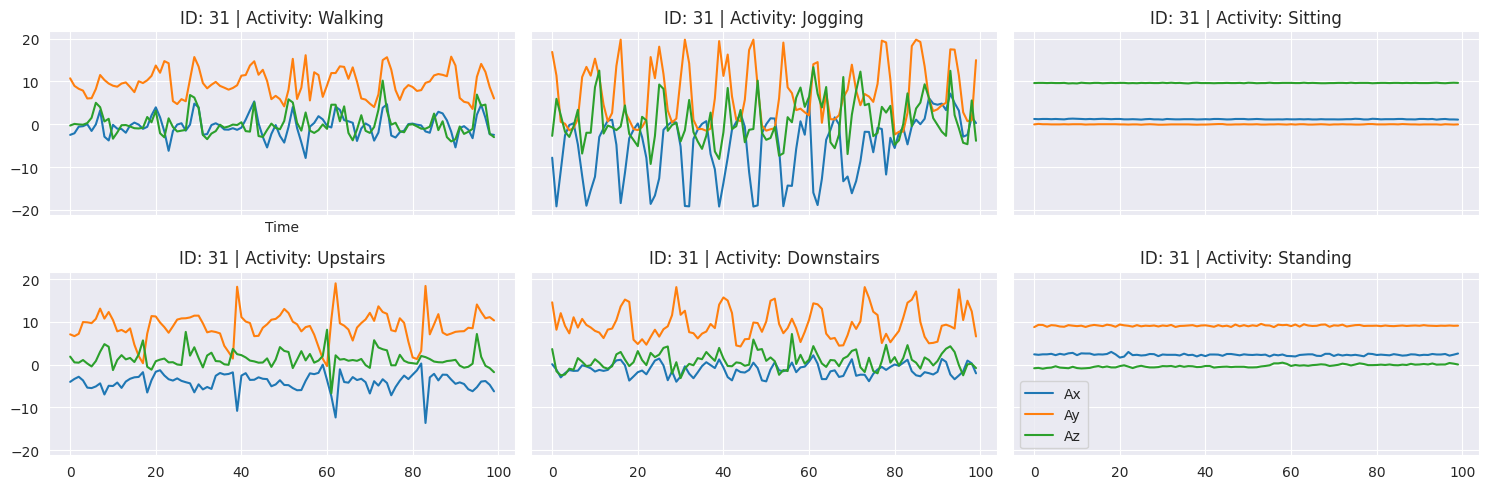

In [9]:
ID = 31
activities = ['Walking', 'Jogging', 'Sitting', 'Upstairs', 'Downstairs', 'Standing']

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.flatten()
for i, activity in enumerate(activities):
    if activity is not None:
        idx = feature_df[(feature_df["ID"] == ID) * (feature_df["label"]==activity)].index[0]
        ax[i].plot(np.array(acc[idx])[:, 0], label="Ax")
        ax[i].plot(np.array(acc[idx])[:, 1], label="Ay")
        ax[i].plot(np.array(acc[idx])[:, 2], label="Az")
        ax[i].set_title(f"ID: {ID} | Activity: {activity}")
ax[0].set_xlabel("Time")
plt.legend()
plt.tight_layout()
fig.savefig("images/Sample31.png", dpi=300)

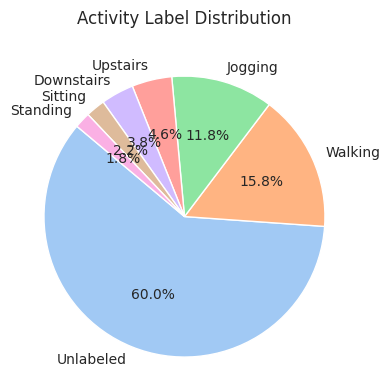

In [10]:
# Pie Chart of Activity Distribution
# activity_counts = feature_df['label'].value_counts()
activity_counts = df['activity'].replace(np.nan, 'Unlabeled').value_counts()
fig, ax = plt.subplots(figsize=(4, 4))
ax.pie(
    activity_counts, labels=activity_counts.index,
    autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'),
)
ax.set_title("Activity Label Distribution\n")
plt.axis('equal')  # Equal aspect ratio ensures the pie is circular
plt.tight_layout()
fig.savefig("images/Pie.png", dpi=300)

This makes sense as we usually put on a fitness watch to collect physilocial data mostly during *walking* and *jogging*!  

Before feature extraction

In [11]:
# Dimensionality reduction (PCA)
from sklearn.decomposition import PCA

features_only = df.dropna()[['X', 'Y', 'Z']]
labels_only = df.dropna()['activity']

pca_orgData = PCA(n_components=2)
pca_orgData_result = pca_orgData.fit_transform(features_only)

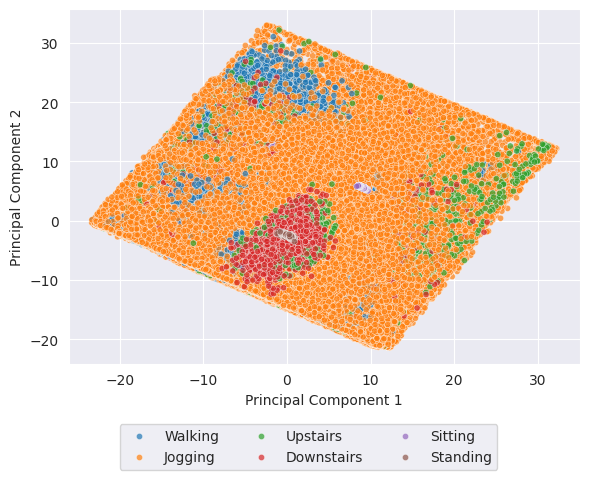

In [12]:
fig, ax = plt.subplots(figsize=(6, 5))
sns.scatterplot(x=pca_orgData_result[:, 0], y=pca_orgData_result[:, 1],
                hue=labels_only, palette='tab10', s=20, alpha=0.7, ax=ax)
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.legend(ncols=3, loc=[0.1, -0.3])

plt.tight_layout()
fig.savefig("images/PCA_OrigData.png", dpi=300)

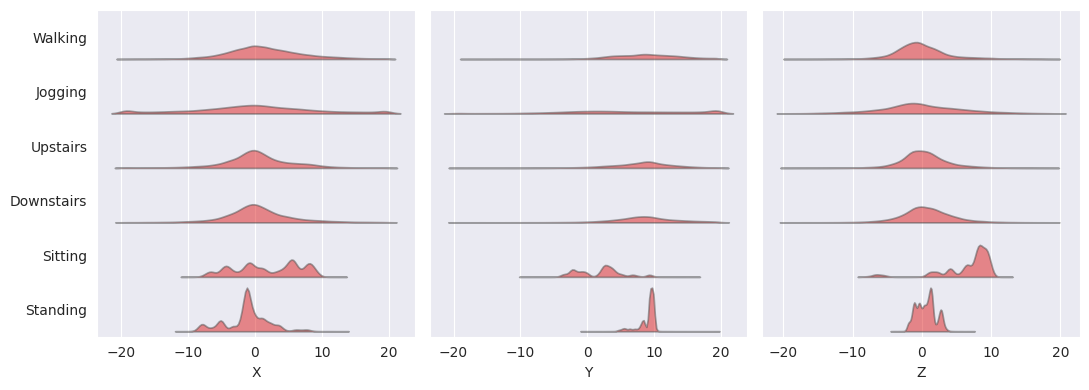

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(11, 4), sharey=True)
ax = ax.flatten()

for i, feature in enumerate(['X', 'Y', 'Z']):
    sns.violinplot(df, x=feature, y='activity', ax=ax[i],
                split=True, inner=None, alpha=0.5, color='r'
                )
    ax[i].set_ylabel("")
plt.tight_layout()
fig.savefig("images/XYZDist.png", dpi=300)

After (window based) feature extraction

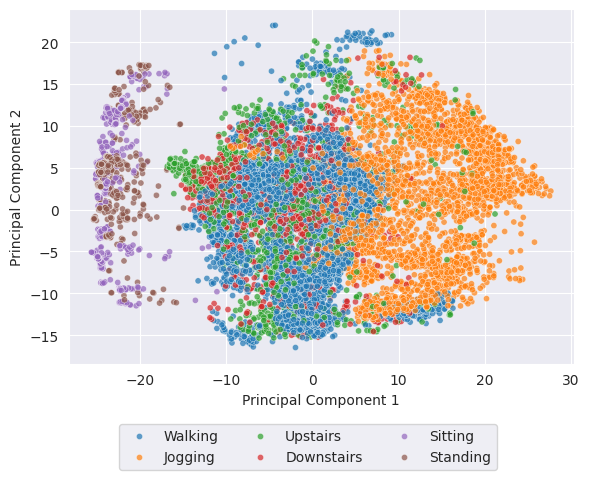

In [14]:
# Dimensionality reduction (PCA)
from sklearn.decomposition import PCA

features_only = feature_df.drop(columns=['label', 'ID'], errors='ignore')
labels_only = feature_df['label']

pca_transData = PCA(n_components=3)
pca_transData_result = pca_transData.fit_transform(features_only)

fig, ax = plt.subplots(figsize=(6, 5))
sns.scatterplot(x=pca_transData_result[:, 0], y=pca_transData_result[:, 1],
                hue=labels_only, palette='tab10', s=20, alpha=0.7, ax=ax)
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.legend(ncols=3, loc=[0.1, -0.3])

plt.tight_layout()
fig.savefig("images/PCA_TransData.png", dpi=300)

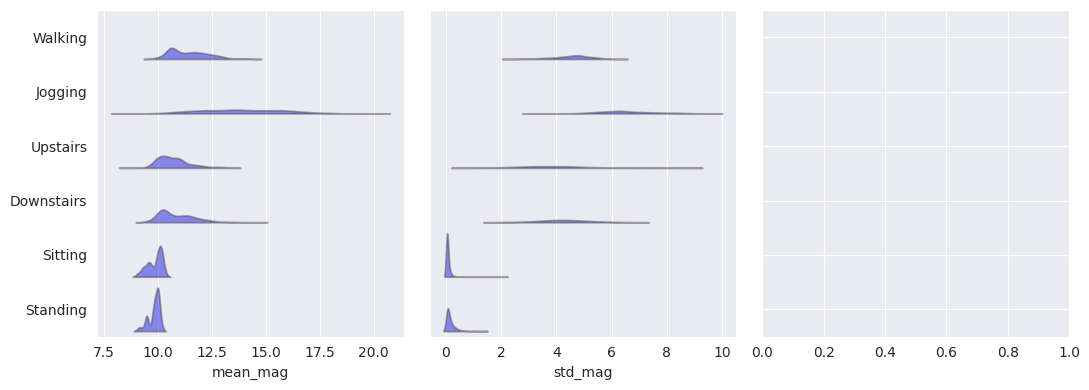

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(11, 4), sharey=True)
ax = ax.flatten()


for i, feature in enumerate(['mean_mag', 'std_mag']):
    sns.violinplot(feature_df, x=feature, y='label', ax=ax[i],
                # legend=True if feature=='dom_freq_X' else False,
                split=True, inner=None, alpha=0.5, color='b'
                )
    ax[i].set_ylabel("")
plt.tight_layout()
fig.savefig("images/Mag.png", dpi=300)

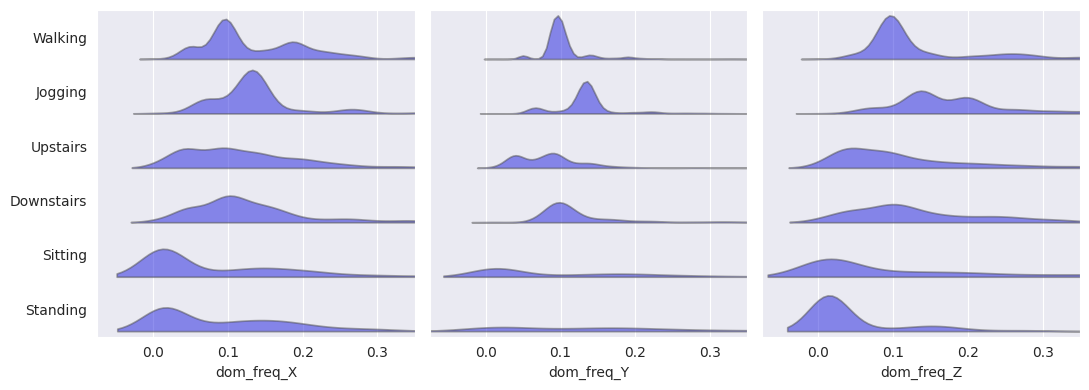

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(11, 4), sharey=True)
ax = ax.flatten()


for i, feature in enumerate(['dom_freq_X', 'dom_freq_Y', 'dom_freq_Z']):
    sns.violinplot(feature_df, x=feature, y='label', ax=ax[i],
                # legend=True if feature=='dom_freq_X' else False,
                split=True, inner=None, alpha=0.5, color='b'
                )
    ax[i].set_ylabel("")
    ax[i].set_xlim([-0.075, 0.35])

plt.tight_layout()
fig.savefig("images/DomFreq.png", dpi=300)

## 4. Data Splitting

In [17]:
# IDs assigned to the test set
test_ids = np.arange(31, 37)

# Train set: windows from IDs not in test_ids
train_df = feature_df[~feature_df['ID'].isin(test_ids)].reset_index(drop=True)
test_df  = feature_df[ feature_df['ID'].isin(test_ids)].reset_index(drop=True)

# Separate features and labels
X_train, y_train= train_df.drop(columns=['label','ID']), train_df['label']
X_test, y_test  = test_df.drop(columns=['label','ID']), test_df['label']
print("Total windows:", feature_df.shape[0],
      "-- Train windows:", len(X_train), ", Test windows:", len(X_test))
print("Labeled train windows:", y_train.notna().sum(),
      "| Unlabeled train windows:", y_train.isna().sum())
print("Labeled test windows:", y_test.notna().sum(),
      "| Unlabeled test windows:", y_test.isna().sum())

Total windows: 20565 -- Train windows: 16776 , Test windows: 3789
Labeled train windows: 8604 | Unlabeled train windows: 8172
Labeled test windows: 2053 | Unlabeled test windows: 1736


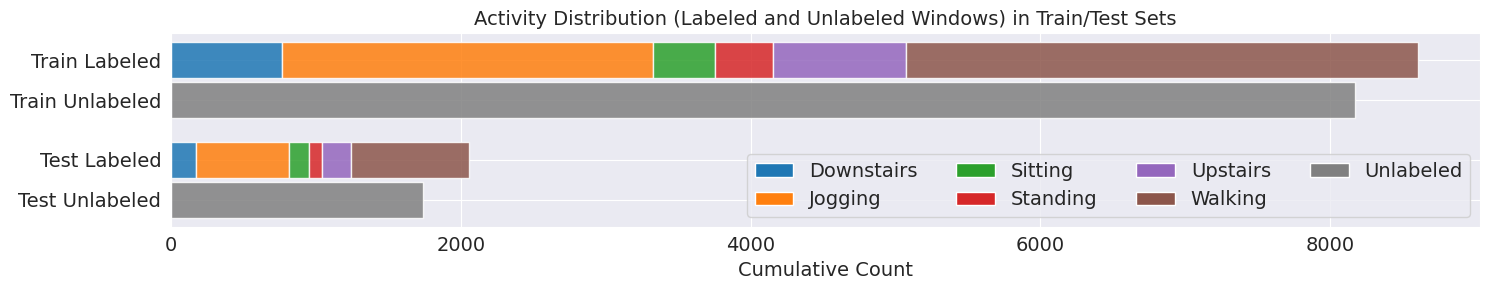

In [18]:
# Split plot
from matplotlib.patches import Patch

# --- Count preparation ---
# Labeled
train_labeled = train_df[train_df['label'].notna()]
test_labeled = test_df[test_df['label'].notna()]
train_counts = train_labeled['label'].value_counts()
test_counts = test_labeled['label'].value_counts()

# Unlabeled
train_unlab_count = train_df['label'].isna().sum()
test_unlab_count = test_df['label'].isna().sum()

# Ensure consistent ordering
all_labels = sorted(set(train_counts.index).union(test_counts.index))
train_counts = train_counts.reindex(all_labels, fill_value=0)
test_counts = test_counts.reindex(all_labels, fill_value=0)

# Colors
palette = sns.color_palette("tab10", len(all_labels))
color_dict = dict(zip(all_labels, palette))
unlabel_color = "grey"

# --- Plotting ---
fig, ax = plt.subplots(figsize=(15, 3))
bar_height = 0.18
y_pos = {
    'Train Labeled': 0.85,
    'Train Unlabeled': 0.65,
    'Test Labeled': 0.35,
    'Test Unlabeled': 0.15,
}

# Plot labeled Train
left = 0
for label in all_labels:
    count = train_counts[label]
    ax.barh(y_pos['Train Labeled'], count, left=left, color=color_dict[label], height=bar_height, alpha=0.85)
    left += count

# Plot labeled Test
left = 0
for label in all_labels:
    count = test_counts[label]
    ax.barh(y_pos['Test Labeled'], count, left=left, color=color_dict[label], height=bar_height, alpha=0.85)
    left += count

# Plot Unlabeled Train
ax.barh(y_pos['Train Unlabeled'], train_unlab_count, color=unlabel_color, height=bar_height, alpha=0.85)

# Plot Unlabeled Test
ax.barh(y_pos['Test Unlabeled'], test_unlab_count, color=unlabel_color, height=bar_height, alpha=0.85)

# Y-ticks
ax.set_yticks(list(y_pos.values()))
ax.set_yticklabels(list(y_pos.keys()), fontsize=14)

# Tick label sizes
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

# Legend
legend_elements = [Patch(facecolor=color_dict[label], label=label) for label in all_labels]
legend_elements.append(Patch(facecolor=unlabel_color, label='Unlabeled'))
ax.legend(handles=legend_elements, ncols=4, loc="lower right", fontsize=14)#, title='Activity', bbox_to_anchor=(1.02, 1), loc='upper left')

# Labels and title
ax.set_xlabel("Cumulative Count", fontsize=14)
ax.set_title("Activity Distribution (Labeled and Unlabeled Windows) in Train/Test Sets", fontsize=14)

plt.tight_layout()
plt.savefig("images/Activity_Distribution_Labeled_Unlabeled.png", dpi=300)

In [19]:
# Check the cross-subject split criterion
train_subjects = train_df['ID'].unique()
test_subjects = test_df['ID'].unique()

print(f"Total unique subjects: {feature_df['ID'].nunique()}")
print(f"Train subjects ({len(train_subjects)}): {train_subjects}")
print(f"Test subjects ({len(test_subjects)}): {test_subjects}")

# Verify no overlap
assert len(set(train_subjects).intersection(set(test_subjects))) == 0, "Subject overlap between train and test!"
print("\n✅ No subject overlap between train and test sets.")

Total unique subjects: 36
Train subjects (30): [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Test subjects (6): [31 32 33 34 35 36]

✅ No subject overlap between train and test sets.


In [20]:
# Check representation of activities in train/test
activity_counts_train = train_df['label'].value_counts(dropna=False)
activity_counts_test = test_df['label'].value_counts(dropna=False)

activity_representation = pd.DataFrame({
    'Train Count': activity_counts_train,
    'Test Count': activity_counts_test
}).fillna(0).astype(int)

print("\nActivity representation in Train/Test:")
print(activity_representation)


Activity representation in Train/Test:
            Train Count  Test Count
None               8172        1736
Walking            3532         809
Jogging            2557         643
Upstairs            920         200
Downstairs          768         169
Sitting             432         140
Standing            395          92


In [21]:
# Verify that all activities appear in both sets
missing_activities_train = activity_representation[activity_representation['Train Count']==0].index.tolist()
missing_activities_test = activity_representation[activity_representation['Test Count']==0].index.tolist()

if missing_activities_train:
    print(f"\n⚠️ Activities missing in train set: {missing_activities_train}")
else:
    print("\n✅ All activities represented in train set.")

if missing_activities_test:
    print(f"⚠️ Activities missing in test set: {missing_activities_test}")
else:
    print("✅ All activities represented in test set.")


✅ All activities represented in train set.
✅ All activities represented in test set.


In [22]:
# Stratification check (especially important for rare activities like "Standing")
rare_activities = activity_representation[(activity_representation.sum(axis=1) < 0.05 * feature_df.shape[0])].index.tolist()
print("\nRare activities (<5% total dataset):", rare_activities)


Rare activities (<5% total dataset): ['Downstairs', 'Sitting', 'Standing']


In [23]:
# Check distribution of rare activities across subjects
for activity in rare_activities:
    subjects_with_activity = feature_df[feature_df['label'] == activity]['ID'].unique()
    subjects_in_train = set(subjects_with_activity).intersection(set(train_subjects))
    subjects_in_test = set(subjects_with_activity).intersection(set(test_subjects))
    print(f"\nActivity '{activity}':")
    print(f"- Total subjects with activity: {len(subjects_with_activity)}")
    print(f"- Train subjects with activity: {sorted(subjects_in_train)}")
    print(f"- Test subjects with activity: {sorted(subjects_in_test)}")
    if not subjects_in_test:
        print(f"⚠️ No test subjects for rare activity '{activity}'!")


Activity 'Downstairs':
- Total subjects with activity: 32
- Train subjects with activity: [1, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30]
- Test subjects with activity: [31, 32, 33, 34, 36]

Activity 'Sitting':
- Total subjects with activity: 23
- Train subjects with activity: [3, 4, 5, 6, 7, 8, 12, 13, 16, 18, 19, 20, 21, 24, 27, 29, 30]
- Test subjects with activity: [31, 32, 33, 34, 35, 36]

Activity 'Standing':
- Total subjects with activity: 24
- Train subjects with activity: [3, 5, 6, 7, 8, 10, 12, 13, 16, 18, 19, 20, 21, 24, 27, 28, 29, 30]
- Test subjects with activity: [31, 32, 33, 34, 35, 36]


In [24]:
# Activity Coverage in Test Set – check that multiple subjects performed each activity in test set
print("\nChecking activity coverage in test set:")
activity_coverage_test = feature_df[feature_df['ID'].isin(test_ids)].groupby('label')['ID'].nunique()

for activity, count in activity_coverage_test.items():
    print(f"- Activity '{activity}' performed by {count} test subjects")
    if count < 2:
        print(f"⚠️ Activity '{activity}' has low test subject coverage")
    else:
        print(f"✅ Good coverage for activity '{activity}' in test set")

# Check if any subject in the test set performed all activities
all_activities = feature_df['label'].dropna().unique()
subjects_with_all_activities = []
for subject_id in test_ids:
    subject_activities = feature_df[(feature_df['ID'] == subject_id) & (feature_df['label'].notna())]['label'].unique()
    if set(all_activities).issubset(set(subject_activities)):
        subjects_with_all_activities.append(subject_id)

print("\nSubjects in test set who performed ALL activities:", subjects_with_all_activities)
if len(subjects_with_all_activities) >= 2:
    print("✅ Multiple test subjects performed ALL activities")
else:
    print("⚠️ Less than 2 test subjects performed ALL activities")


Checking activity coverage in test set:
- Activity 'Downstairs' performed by 5 test subjects
✅ Good coverage for activity 'Downstairs' in test set
- Activity 'Jogging' performed by 6 test subjects
✅ Good coverage for activity 'Jogging' in test set
- Activity 'Sitting' performed by 6 test subjects
✅ Good coverage for activity 'Sitting' in test set
- Activity 'Standing' performed by 6 test subjects
✅ Good coverage for activity 'Standing' in test set
- Activity 'Upstairs' performed by 5 test subjects
✅ Good coverage for activity 'Upstairs' in test set
- Activity 'Walking' performed by 6 test subjects
✅ Good coverage for activity 'Walking' in test set

Subjects in test set who performed ALL activities: [31, 32, 33, 34, 36]
✅ Multiple test subjects performed ALL activities


In [25]:
# Optional: Leave-One-Subject-Out (LOSO) Cross-Validation preparation
from sklearn.model_selection import LeaveOneGroupOut

logo = LeaveOneGroupOut()
X = feature_df.drop(['label', 'ID'], axis=1)
y = feature_df['label']
groups = feature_df['ID']

print("\nPerforming Leave-One-Subject-Out Cross-Validation:")
fold = 1
for train_idx, test_idx in logo.split(X, y, groups):
    train_ids, test_id = groups.iloc[train_idx].unique(), groups.iloc[test_idx].unique()
    print(f"- Fold {fold}: Train subjects ({len(train_ids)}) - Test subject {test_id}")
    fold += 1


Performing Leave-One-Subject-Out Cross-Validation:
- Fold 1: Train subjects (35) - Test subject [1]
- Fold 2: Train subjects (35) - Test subject [2]
- Fold 3: Train subjects (35) - Test subject [3]
- Fold 4: Train subjects (35) - Test subject [4]
- Fold 5: Train subjects (35) - Test subject [5]
- Fold 6: Train subjects (35) - Test subject [6]
- Fold 7: Train subjects (35) - Test subject [7]
- Fold 8: Train subjects (35) - Test subject [8]
- Fold 9: Train subjects (35) - Test subject [9]
- Fold 10: Train subjects (35) - Test subject [10]
- Fold 11: Train subjects (35) - Test subject [11]
- Fold 12: Train subjects (35) - Test subject [12]
- Fold 13: Train subjects (35) - Test subject [13]
- Fold 14: Train subjects (35) - Test subject [14]
- Fold 15: Train subjects (35) - Test subject [15]
- Fold 16: Train subjects (35) - Test subject [16]
- Fold 17: Train subjects (35) - Test subject [17]
- Fold 18: Train subjects (35) - Test subject [18]
- Fold 19: Train subjects (35) - Test subject [1

## 5. Data Augmentation

In [26]:
# Aug methods: noise, scaling, rotate, invert, reverse_time, permutation, scramble, magnitude_warp, time_warp
skip_some_aug = ["rotate", "invert", "permutation", "magnitude_warp"]
# skip_some_aug = None

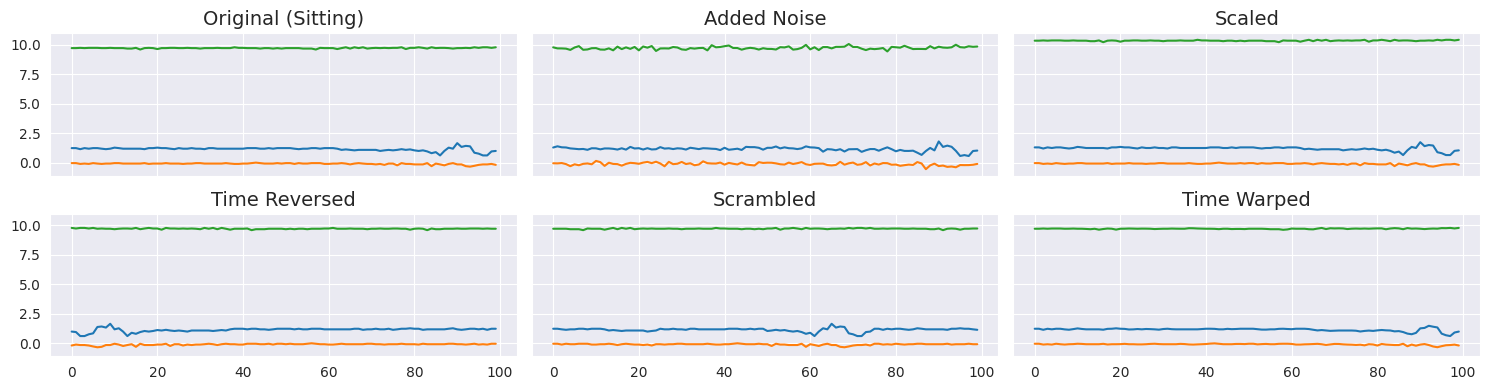

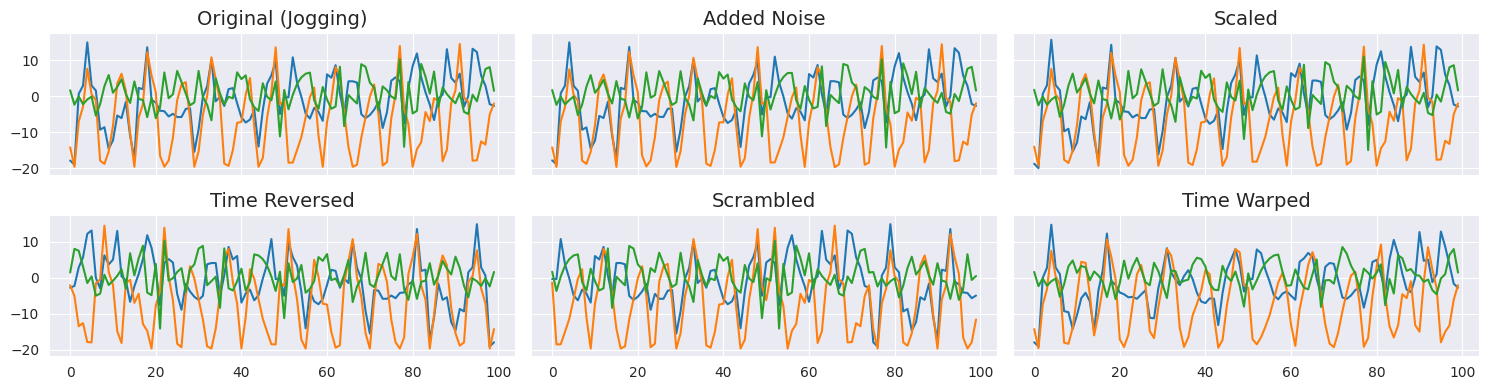

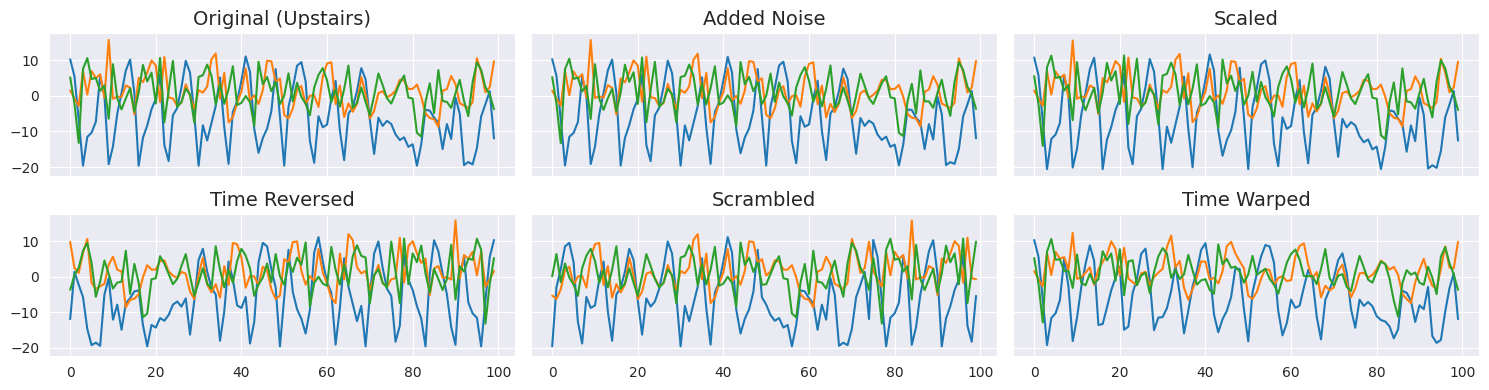

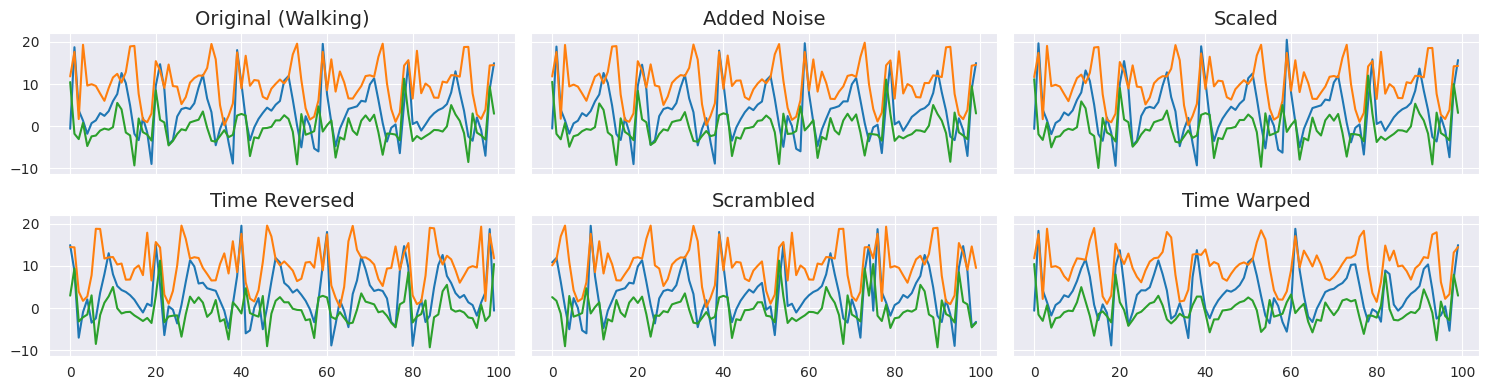

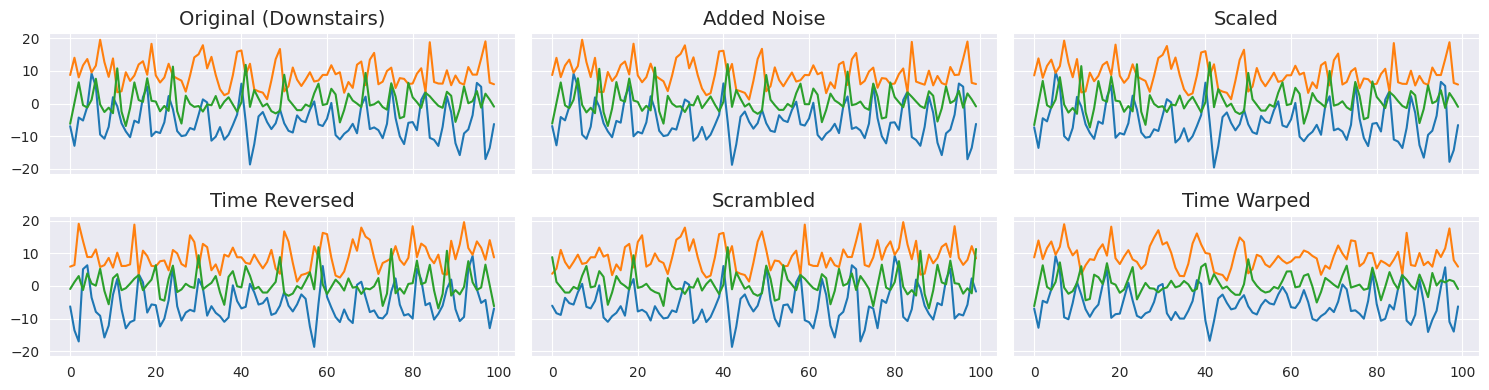

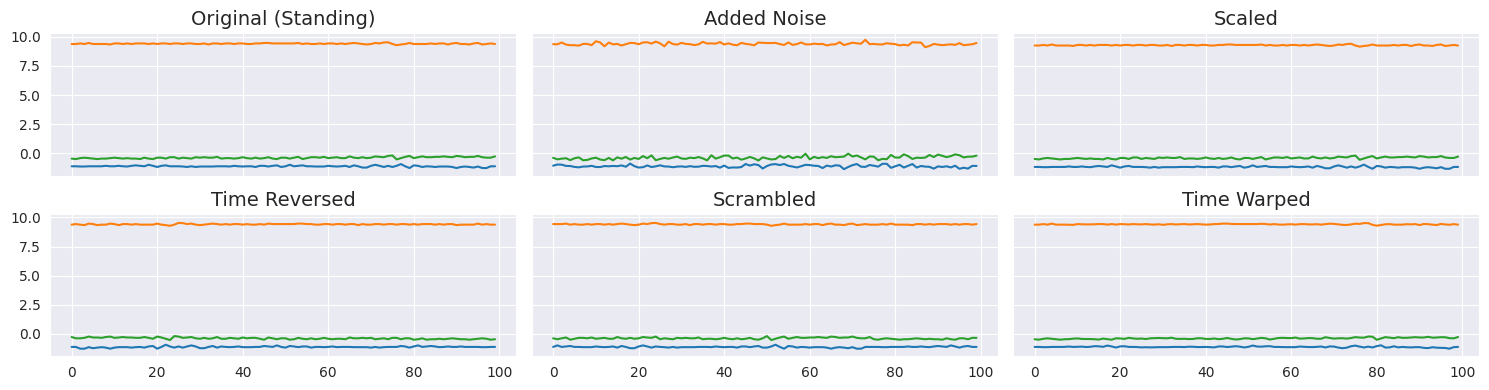

In [27]:
# Visualize Single Window Augmentation
import matplotlib.pyplot as plt, seaborn as sns
sns.set_style("darkgrid")

from utilities import augment_window

for s in list(set(labels)):
    if s is not None:
        mask = np.array(labels) == s
        example_window = np.array(acc)[mask][10]
        augmented_windows = augment_window(example_window, skip_some_aug)

        fig, axes = plt.subplots(2, len(augmented_windows)//2 + 1, figsize=(15, 4), sharey=True, sharex=True)
        axes = axes.flatten()
        if skip_some_aug is not None:
            titles = [f'Original ({s})', 'Added Noise', 'Scaled', 'Time Reversed', 'Scrambled', 'Time Warped']
        else:
            titles = [f'Original ({s})', 'Added Noise', 'Scaled', 'Rotated', 'Inverted', 'Time Reversed',
                      'Permutated', 'Scrambled', 'Magnitude Warped', 'Time Warped']
        all_windows = [example_window] + augmented_windows

        for i, window in enumerate(all_windows):
            axes[i].plot(window)
            axes[i].set_title(titles[i], fontsize=14)
            axes[i].grid(True)

    plt.tight_layout()
    fig.savefig(f"images/Augmentations_{s}{'_skip_some_aug' if skip_some_aug is not None else ''}.png", dpi=300)

In [28]:
# Augment Training Data
from utilities import augment_df

train_df_augmented = augment_df(train_df, acc, skip_some_aug)

# Check overlap between train and test set
train_subjects = train_df_augmented['ID'].unique()
test_subjects = test_df['ID'].unique()
print(f"Train subjects ({len(train_subjects)}): {train_subjects}")
print(f"Test subjects ({len(test_subjects)}): {test_subjects}")
assert len(set(train_subjects).intersection(set(test_subjects))) == 0, "Subject overlap between train and test!"
print("\n✅ No subject overlap between train and test sets.")


Performing data augmentation on labelled train windows...
Augmented feature set shape: (43020, 22)
Total training data after augmentation: (59796, 22)
Train subjects (30): [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Test subjects (6): [31 32 33 34 35 36]

✅ No subject overlap between train and test sets.


In [29]:
# Handle imbalanced data
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# Step 1: Split labeled and unlabeled
train_df_labeled = train_df_augmented[train_df_augmented['label'].notna()]
train_df_unlabeled = train_df_augmented[train_df_augmented['label'].isna()]

# Step 2: SMOTE on labeled data
X_labeled = train_df_labeled.drop(columns=['label', 'ID'], errors='ignore')
y_labeled = train_df_labeled['label']

# Standardize
scaler = StandardScaler()
X_labeled_scaled = scaler.fit_transform(X_labeled)

# SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_labeled_scaled, y_labeled)

# Reconstruct DataFrame
X_resampled_df = pd.DataFrame(X_resampled, columns=X_labeled.columns)
y_resampled_df = pd.Series(y_resampled, name='label')

# # Reset label or generate dummy IDs if needed
train_df_balanced = X_resampled_df.copy()
train_df_balanced['label'] = y_resampled_df
if 'ID' in train_df_labeled.columns:
    train_df_balanced['ID'] = np.zeros(len(train_df_balanced), dtype=int)

# Step 3: Reattach original unlabeled rows
train_df_augmented_balanced_scaled = pd.concat([train_df_balanced, train_df_unlabeled], ignore_index=True)


In [30]:
# Standardize test_df using the same scaler used during SMOTE
X_test = test_df.drop(columns=['label', 'ID'], errors='ignore')
X_test_scaled = scaler.transform(X_test)

# (Optional) Keep as DataFrame
test_df_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# Combine back with label and ID if needed
test_df_scaled[test_df.columns] = test_df

In [32]:
# Save train and test dataframes
train_df_augmented.to_csv("data/train_df_augmented.csv")
test_df.to_csv("data/test_df.csv")

train_df_augmented_balanced_scaled.to_csv("data/train_df_augmented_balanced_scaled.csv")
test_df_scaled.to_csv("data/test_df_scaled.csv")


# Dump raw data to a pickle file
import pickle as pkl

raw_data_dict = {"acc": acc, "win_ids": win_ids, "labels": labels, "ts": ts}
with open('data/raw_data_dict.pkl', 'wb') as f:
    pkl.dump(raw_data_dict, f)